In [44]:
import cv2
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


### Pre Processing

This Function processes a grayscale image to extract signatures into training and testing datasets. It begins by reading the image and applying binary thresholding, followed by morphological operations to clean up the image. The dimensions for each signature are determined based on the total number of rows and signatures per row, allowing for structured extraction. It then creates output directories for training and testing signatures, randomly selecting one signature per row for the testing set. The function iterates through each signature box, extracting the largest contour to obtain the signature. Each extracted signature is resized to 128x128 pixels and saved in the appropriate directory, with print statements providing feedback on saved files and any errors encountered during processing.

This outputs a folder by the name of processed_images, containing two folders, train and test, in which there are picture folders eg. 1, 2 ,3 ,4. In these picture folders there are row folders which contain the signatures.

In [45]:
def extract_signatures_from_image(image_file, output_directory, total_rows=12, total_signatures_per_row=4):
    
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    

    if img is None:
        print(f"Error: Could not load image from {image_file}. Check the path.")
        return

    _, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((2, 2), np.uint8)
    cleaned_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    
    height, width = cleaned_img.shape[:2]

    height_per_row = height // total_rows
    width_per_signature = width // total_signatures_per_row

    image_basename = os.path.basename(image_file).split('.')[0]
    
    train_dir = os.path.join(output_directory, 'train', image_basename)
    test_dir = os.path.join(output_directory, 'test', image_basename)
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for row_index in range(total_rows):
        student_folder_train = os.path.join(train_dir, f'row_{row_index + 1}')
        os.makedirs(student_folder_train, exist_ok=True)
        
        student_folder_test = os.path.join(test_dir, f'row_{row_index + 1}')
        os.makedirs(student_folder_test, exist_ok=True)

        test_index = random.randint(0, total_signatures_per_row - 1)  
        print(f'Row {row_index + 1} - Test index: {test_index}')

        for sig_index in range(total_signatures_per_row):
            x_start = sig_index * width_per_signature
            y_start = row_index * height_per_row
            x_end = (sig_index + 1) * width_per_signature
            y_end = (row_index + 1) * height_per_row
            
            signature = cleaned_img[y_start:y_end, x_start:x_end]
            
            contours, _ = cv2.findContours(signature, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
            
                cropped_signature = signature[y:y+h, x:x+w]

                if cropped_signature.size == 0:
                    print(f"No valid signature in row {row_index + 1}, signature {sig_index + 1}.")
                    continue

                resized_signature = cv2.resize(cropped_signature, (128, 128))
                
                if sig_index == test_index:
                    signature_filename = os.path.join(student_folder_test, f'signature_{sig_index + 1}.png')
                    cv2.imwrite(signature_filename, resized_signature)
                    print(f'Saved to test: {signature_filename}')
                else:

                    signature_filename = os.path.join(student_folder_train, f'signature_{sig_index + 1}.png')
                    cv2.imwrite(signature_filename, resized_signature)
                    print(f'Saved to train: {signature_filename}')


In [59]:

input_images_directory = r'C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\Data'
output_signatures_directory = r'processed_signatures'


if not os.path.exists(output_signatures_directory):
    os.makedirs(output_signatures_directory)

for img_file in os.listdir(input_images_directory):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Only process image files
        full_image_path = os.path.join(input_images_directory, img_file)
        print(f'Starting processing for {full_image_path}...')
        extract_signatures_from_image(full_image_path, output_signatures_directory)

Starting processing for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\Data\1.jpg...
Row 1 - Test index: 3
Saved to train: processed_signatures\train\1\row_1\signature_1.png
Saved to train: processed_signatures\train\1\row_1\signature_2.png
Saved to train: processed_signatures\train\1\row_1\signature_3.png
Saved to test: processed_signatures\test\1\row_1\signature_4.png
Row 2 - Test index: 3
Saved to train: processed_signatures\train\1\row_2\signature_1.png
Saved to train: processed_signatures\train\1\row_2\signature_2.png
Saved to train: processed_signatures\train\1\row_2\signature_3.png
Saved to test: processed_signatures\test\1\row_2\signature_4.png
Row 3 - Test index: 1
Saved to train: processed_signatures\train\1\row_3\signature_1.png
Saved to test: processed_signatures\test\1\row_3\signature_2.png
Saved to train: processed_signatures\train\1\row_3\signature_3.png
Saved to train: processed_signatures\train\1\row_3\signature_4.png
Row 4 - Test index: 2
Saved t

Row 1 - Test index: 2
Saved to train: processed_signatures\train\12\row_1\signature_1.png
Saved to train: processed_signatures\train\12\row_1\signature_2.png
Saved to test: processed_signatures\test\12\row_1\signature_3.png
Saved to train: processed_signatures\train\12\row_1\signature_4.png
Row 2 - Test index: 0
Saved to test: processed_signatures\test\12\row_2\signature_1.png
Saved to train: processed_signatures\train\12\row_2\signature_2.png
Saved to train: processed_signatures\train\12\row_2\signature_3.png
Saved to train: processed_signatures\train\12\row_2\signature_4.png
Row 3 - Test index: 3
Saved to train: processed_signatures\train\12\row_3\signature_1.png
Saved to train: processed_signatures\train\12\row_3\signature_2.png
Saved to train: processed_signatures\train\12\row_3\signature_3.png
Saved to test: processed_signatures\test\12\row_3\signature_4.png
Row 4 - Test index: 0
Saved to test: processed_signatures\test\12\row_4\signature_1.png
Saved to train: processed_signatures

Row 1 - Test index: 2
Saved to train: processed_signatures\train\15\row_1\signature_1.png
Saved to train: processed_signatures\train\15\row_1\signature_2.png
Saved to test: processed_signatures\test\15\row_1\signature_3.png
Saved to train: processed_signatures\train\15\row_1\signature_4.png
Row 2 - Test index: 0
Saved to test: processed_signatures\test\15\row_2\signature_1.png
Saved to train: processed_signatures\train\15\row_2\signature_2.png
Saved to train: processed_signatures\train\15\row_2\signature_3.png
Saved to train: processed_signatures\train\15\row_2\signature_4.png
Row 3 - Test index: 0
Saved to test: processed_signatures\test\15\row_3\signature_1.png
Saved to train: processed_signatures\train\15\row_3\signature_2.png
Saved to train: processed_signatures\train\15\row_3\signature_3.png
Saved to train: processed_signatures\train\15\row_3\signature_4.png
Row 4 - Test index: 1
Saved to train: processed_signatures\train\15\row_4\signature_1.png
Saved to test: processed_signature

Row 1 - Test index: 3
Saved to train: processed_signatures\train\3\row_1\signature_1.png
Saved to train: processed_signatures\train\3\row_1\signature_2.png
Saved to train: processed_signatures\train\3\row_1\signature_3.png
Saved to test: processed_signatures\test\3\row_1\signature_4.png
Row 2 - Test index: 0
Saved to test: processed_signatures\test\3\row_2\signature_1.png
Saved to train: processed_signatures\train\3\row_2\signature_2.png
Saved to train: processed_signatures\train\3\row_2\signature_3.png
Saved to train: processed_signatures\train\3\row_2\signature_4.png
Row 3 - Test index: 1
Saved to train: processed_signatures\train\3\row_3\signature_1.png
Saved to test: processed_signatures\test\3\row_3\signature_2.png
Saved to train: processed_signatures\train\3\row_3\signature_3.png
Saved to train: processed_signatures\train\3\row_3\signature_4.png
Row 4 - Test index: 1
Saved to train: processed_signatures\train\3\row_4\signature_1.png
Saved to test: processed_signatures\test\3\row_

Row 1 - Test index: 1
Saved to train: processed_signatures\train\6\row_1\signature_1.png
Saved to test: processed_signatures\test\6\row_1\signature_2.png
Saved to train: processed_signatures\train\6\row_1\signature_3.png
Saved to train: processed_signatures\train\6\row_1\signature_4.png
Row 2 - Test index: 1
Saved to train: processed_signatures\train\6\row_2\signature_1.png
Saved to test: processed_signatures\test\6\row_2\signature_2.png
Saved to train: processed_signatures\train\6\row_2\signature_3.png
Saved to train: processed_signatures\train\6\row_2\signature_4.png
Row 3 - Test index: 3
Saved to train: processed_signatures\train\6\row_3\signature_1.png
Saved to train: processed_signatures\train\6\row_3\signature_2.png
Saved to train: processed_signatures\train\6\row_3\signature_3.png
Saved to test: processed_signatures\test\6\row_3\signature_4.png
Row 4 - Test index: 3
Saved to train: processed_signatures\train\6\row_4\signature_1.png
Saved to train: processed_signatures\train\6\ro

Row 1 - Test index: 3
Saved to train: processed_signatures\train\9\row_1\signature_1.png
Saved to train: processed_signatures\train\9\row_1\signature_2.png
Saved to train: processed_signatures\train\9\row_1\signature_3.png
Saved to test: processed_signatures\test\9\row_1\signature_4.png
Row 2 - Test index: 2
Saved to train: processed_signatures\train\9\row_2\signature_1.png
Saved to train: processed_signatures\train\9\row_2\signature_2.png
Saved to test: processed_signatures\test\9\row_2\signature_3.png
Saved to train: processed_signatures\train\9\row_2\signature_4.png
Row 3 - Test index: 2
Saved to train: processed_signatures\train\9\row_3\signature_1.png
Saved to train: processed_signatures\train\9\row_3\signature_2.png
Saved to test: processed_signatures\test\9\row_3\signature_3.png
Saved to train: processed_signatures\train\9\row_3\signature_4.png
Row 4 - Test index: 2
Saved to train: processed_signatures\train\9\row_4\signature_1.png
Saved to train: processed_signatures\train\9\ro

### Preparing the data for the model by extracting the images and making labels

This function loads images and their corresponding labels from a specified directory structure, preparing the data for the CNN Model. It initializes two empty lists, images and labels, to store the loaded images and their associated labels. The function iterates through the images folders. Within each image folder, it traverses further into row sub folders which contain signatures. For each image file, it reads the image in grayscale using OpenCV and resizes it to 128x128 pixels to ensure consistency in input size for the CNN. The function then constructs a unique label for each image by extracting the image and row numbers from the folder names. Finally, the function returns two NumPy arrays: one containing the processed images and the other containing their corresponding labels, making it suitable for training and testing in machine learning tasks.

The labels are created as <b>imagenumber_rownumber</b> indicating that this signature was found in a pirticular image on a pirticular row. The CNN model outputs signautre recognition like this as well (1_2 says image1 and row2 signature)

In [47]:
def load_data(directory):
    images = []
    labels = []

    for image_folder in os.listdir(directory):
        for row_folder in os.listdir(os.path.join(directory, image_folder)):
            row_path = os.path.join(directory, image_folder, row_folder)
            for filename in os.listdir(row_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(row_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (128, 128))  # Resize to match CNN input size

                    images.append(img)
                
                    image_number = int(image_folder.split('_')[-1])  
                    row_number = int(row_folder.split('_')[-1])     
                    # Use a unique string for label
                    labels.append(f'{image_number}_{row_number}') 

    return np.array(images), np.array(labels)

This code snippet defines directories for the signature images and uses the load_data function to load the images and labels into X_train, labels_train, X_test, and labels_test. The images are normalized by converting them to float32 and scaling pixel values to [0, 1].

A LabelEncoder is fitted with combined labels from both datasets, and the labels are transformed into integer-encoded values. Finally, one-hot encoding converts these integer labels into binary matrices (y_train and y_test), readying the data for model training and evaluation.

In [60]:

train_dir = r'C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\train'
test_dir = r'C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test'

X_train, labels_train = load_data(train_dir)

X_test, labels_test = load_data(test_dir)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate((labels_train, labels_test)))  


label_encoded_train = label_encoder.transform(labels_train)
label_encoded_test = label_encoder.transform(labels_test)

# one hot encoding
y_train = to_categorical(label_encoded_train, num_classes=len(label_encoder.classes_))
y_test = to_categorical(label_encoded_test, num_classes=len(label_encoder.classes_))


### Creating the Model

The create_cnn_model function creates a sequential model. It features two convolutional layers with ReLU activation and L2 regularization, each followed by max pooling and dropout layers to enhance feature extraction and reduce overfitting. After flattening the pooled outputs, a dense layer with 128 neurons and another dropout layer precede the final output layer, which uses softmax activation to predict class probabilities based on the number of signature types. The model is compiled with the Adam optimizer and categorical crossentropy loss, optimizing for classification accuracy.

In [49]:
def create_cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), 
                     kernel_regularizer=l2(0.001)))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))  

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))  

    model.add(Flatten())

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))  # Add Dropout layer

    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [61]:
cnn_model = create_cnn_model()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model history is recorded for plots and the model is saved for future use. Early Stopping also implemented

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#creating the model and saving it for later use 
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping],batch_size=32)

model_save_path = 'signature_cnn_model.h5'
cnn_model.save(model_save_path)
print(f'Model saved to {model_save_path}')

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.2024 - loss: 4.0910 - val_accuracy: 0.0994 - val_loss: 5.1965
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.4052 - loss: 3.0478 - val_accuracy: 0.0939 - val_loss: 5.2121
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - accuracy: 0.6017 - loss: 2.0423 - val_accuracy: 0.1271 - val_loss: 5.4290
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.7425 - loss: 1.5752 - val_accuracy: 0.1436 - val_loss: 5.7218
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.8143 - loss: 1.3849 - val_accuracy: 0.1326 - val_loss: 6.0289
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.8320 - loss: 1.2835 - val_accuracy: 0.1326 - val_loss: 6.3555


Model saved to signature_cnn_model.h5


Evaluating the Model on the test set

In [69]:

test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1262 - loss: 5.1229
Test Loss: 5.196506023406982
Test Accuracy: 0.09944751113653183


In [70]:
# Evaluate the model on the training data
train_loss, train_accuracy = cnn_model.evaluate(X_train, y_train, verbose=1)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7512 - loss: 2.7430
Train Loss: 2.7983555793762207
Train Accuracy: 0.7132353186607361


### Prediction Function Signatures

The function makes prediction for a single image and returns the label. It reads the image in grayscale and checks for loading errors, resizing it to 128x128 pixels and normalizing pixel values to the range of 0 to 1. The image is then reshaped to match the model's expected input format, adding dimensions for batch size and channels. After making a prediction, it decodes the predicted class index back to its corresponding label using the label encoder and returns this label, indicating the recognized signature class. This function is essential for evaluating individual signatures against the trained model.

In [54]:
def predict_signature(model, image_path, label_encoder):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise FileNotFoundError(f"Error: Could not load image from {image_path}. Check if the file exists and the path is correct.")
    
    img = cv2.resize(img, (128, 128)).astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  
    img = np.expand_dims(img, axis=0)   
    
    prediction = model.predict(img)
    decoded_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return decoded_label


The function iterates through all the test images of signatures organized into subfolders. For each image file, it constructs the full file path and calls the previously defined predict_signature function to obtain the predicted label for the signature. If the image is successfully loaded and processed, the predicted label is printed alongside the image path. If a FileNotFoundError occurs, the error message is printed instead.

In [55]:
def predict_all_signatures_in_test_folder(model, test_dir, label_encoder):

    for image_folder in os.listdir(test_dir):
        for row_folder in os.listdir(os.path.join(test_dir, image_folder)):
            row_path = os.path.join(test_dir, image_folder, row_folder)
            for filename in os.listdir(row_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(row_path, filename)
                    
                    try:
                        predicted_label = predict_signature(model, img_path, label_encoder)
                        print(f'Predicted label for {img_path}: {predicted_label}')
                    except FileNotFoundError as e:
                        print(e)


In [65]:
test_dir = r'C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test'

# Call the function to predict all test signatures
predict_all_signatures_in_test_folder(cnn_model, test_dir, label_encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\1\row_1\signature_4.png: ['1_11']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\1\row_10\signature_4.png: ['2_2']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\1\row_11\signature_1.png: ['3_3']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\1\row_2\signature_4.png: ['3_6']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\1\row_3\signature_2.png: ['2_2']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted label for C:\Users\

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\12\row_12\signature_4.png: ['5_5']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\12\row_2\signature_1.png: ['7_4']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\12\row_3\signature_4.png: ['2_2']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\12\row_4\signature_1.png: ['13_9']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\12\row_5\signature_3.png: ['3_1']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for C:\Us

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\15\row_5\signature_1.png: ['15_9']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\15\row_6\signature_2.png: ['5_5']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\15\row_7\signature_4.png: ['15_9']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\15\row_8\signature_1.png: ['4_1']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\15\row_9\signature_3.png: ['12_10']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for C:\

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\4\row_1\signature_3.png: ['14_2']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\4\row_10\signature_1.png: ['8_10']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\4\row_11\signature_2.png: ['3_1']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\4\row_12\signature_2.png: ['13_4']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\4\row_2\signature_3.png: ['3_6']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted label for C:\Use

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\7\row_11\signature_3.png: ['13_4']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\7\row_2\signature_2.png: ['1_11']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\7\row_3\signature_4.png: ['2_2']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\7\row_4\signature_3.png: ['2_2']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label for C:\Users\Lenovo\Documents\Abds work\S7\Gen AI\Assignment_1_upload\Q1\processed_signatures\test\7\row_5\signature_1.png: ['10_8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for C:\Users

### Plotting the Results

The function visualizes the training and validation metrics from a Keras model's training history. It extracts loss and accuracy values for both datasets, calculates the number of epochs, and creates DataFrames for plotting. The function sets up two subplots: the first subplot displays loss values on the y-axis against epochs on the x-axis, while the second subplot shows accuracy values on the y-axis versus epochs on the x-axis. The y-axis limits are adjusted for clarity, and the plots are shown in a cohesive layout, providing an insightful overview of the model's performance throughout training.

In [66]:
def plot_training_history(history):
    
   
    train_loss_values = history.history['loss'] 
    train_accuracy_values = history.history['accuracy']  
    test_loss_values = history.history['val_loss'] 
    test_accuracy_values = history.history['val_accuracy']  

    n_epochs = len(train_loss_values)
    epochs = list(range(1, n_epochs + 1))  


    df_loss = pd.DataFrame({
        'Epoch': epochs * 2,
        'Loss': train_loss_values + test_loss_values,
        'Dataset': ['Train'] * n_epochs + ['Test'] * n_epochs
    })


    df_accuracy = pd.DataFrame({
        'Epoch': epochs * 2,
        'Accuracy': train_accuracy_values + test_accuracy_values,
        'Dataset': ['Train'] * n_epochs + ['Test'] * n_epochs
    })

    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Dataset', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.ylim(0, max(df_loss['Loss']) + 0.1)  

    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df_accuracy, x='Epoch', y='Accuracy', hue='Dataset', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Value')
    plt.ylim(0, 1)  

    plt.tight_layout()
    plt.show()


Calling the Function...

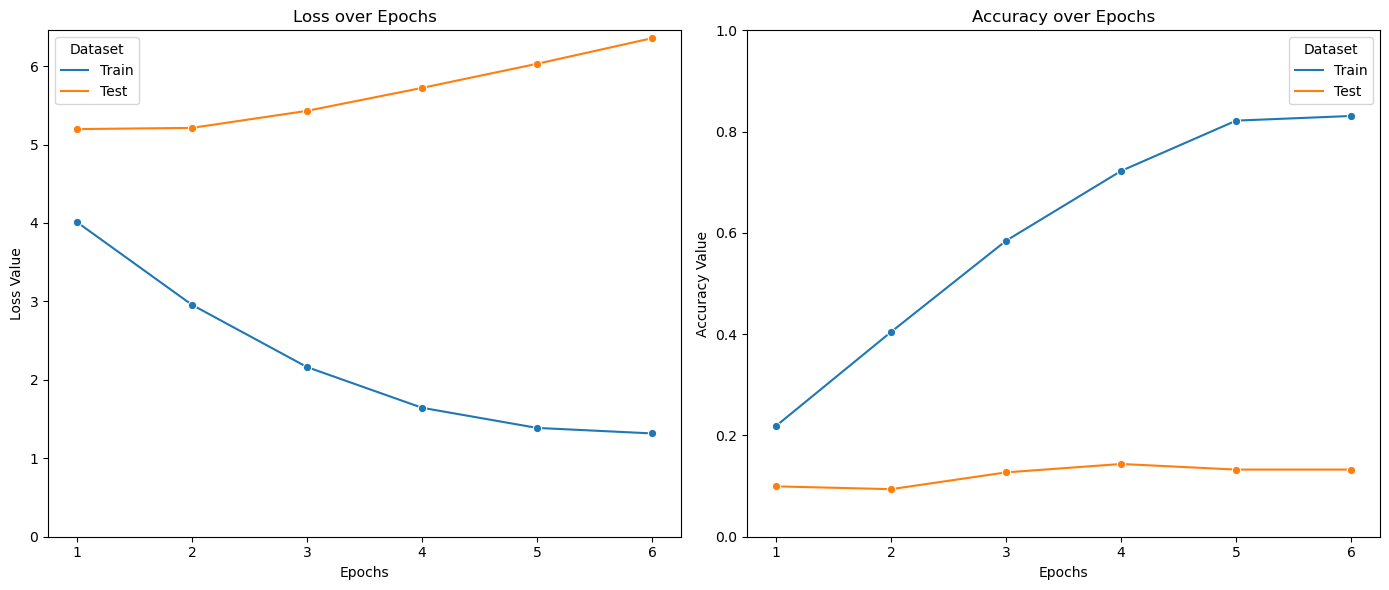

In [71]:
plot_training_history(history)

### The Confusion Matrix 

Evaluates the models performace based on the test set. It predicts class probabilities with cnn_model.predict(X_test) and converts these to class labels using np.argmax. It also retrieves the true labels from the one-hot encoded format. The classification_report(y_true, y_pred) generates metrics like precision and recall for each class, while confusion_matrix(y_true, y_pred) provides a matrix that visualizes correct and incorrect predictions for each class.

In [26]:
# Ensure X_test has the right shape for prediction to match the shape of the training set
X_test = np.expand_dims(X_test, axis=-1) 


In [27]:
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  

y_true = np.argmax(y_test, axis=1)


print(classification_report(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.33      1.00      0.50         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\

### Conclusion

Gives an accuracy of 12%, precision of 9%, recall of 12% and F1 Score of 10% on 179 samples of test data. The total number of calsses are 185.